# Understanding Polymer Graph Featurization : Monomers → Graphs → Vectors

## Table of Contents:
1. [Introduction](#introduction)
2. [Programmatic Conversion](#progconv)
      - [Conversion Considerations](#convConsid)
3. [Data Aggregation](#dataAgg)
4. [Data Finalization](#dataFinal)
5. [Graph Visualization](#dataVis)
6. [Featurization](#feat)
7. [Summary](#sum)
8. [Reference](#ref)

In [1]:
! pip install rdkit

## 1. Introduction <a class="anchor" id="introduction"></a>

Polymers are fascinating materials with a wide range of applications, from manufacturing to biology. However, controlling the manufacturing of polymers with defined properties can be quite challenging. For instance, if I want to develop a polymer composite matrix that uses ceramic as a filler, I need to balance high mechanical properties with manageable thermal properties while considering production costs. Suppose I have an existing inventory of polymers and need to validate the best set for this application or develop new polymer chains specific to this use case. It could be expensive both experimentally and economically. Can AI help in this case ? Absolutely yes. But how can we effectively convert these polymer chains into a computer-readable format? To do this, we must understand how polymers are formed and processed.

Polymers are created by combining a large number of defined repeating units called monomers. These monomers can be of various types, connected in different ratios and at different open bonds, resulting in a diverse array of materials with the same repeating units. The criteria and different conjunction points of repetition can significantly alter the properties of the material.

This concept is similar to creating an ornament. A simple ornament might consist of repetitive elements like pebbles or stones. However, more intricate and beautiful designs require considerations of branching, convergence at certain points, and the distribution of different materials such as stones, diamonds, and metals. Similarly, for industrially applicable polymers, various functionally branched polymers are connected to different open bonds with varying material proportions, resulting in a final polymer chain.

Now that we understand it's not as simple as just repeating structures, how can we represent polymers effectively? One possibility is using a SMILES string sequence, but how long should this sequence be? The repetition of the sequence can be very high. 

Imagine we create a representation format where we store the repetitive unit with SMILES strings and the number of repetitions as a number. When dealing with copolymers containing multiple monomers, the repetition numbers might vary for each repeating unit. We might develop another format to store each repeating unit followed by its number of repetitions. However, this raises questions about the inclusion of connection variations between monomers at different open bonds. In such cases, we might switch to graph data structures rather than sequential strings. 

There could be other representation mechanisms as well. For more details, refer to the tutorial available by clicking on this [link](https://deepchem.io/tutorials/an-introduction-to-the-polymers-and-their-representation/).

Converting a monomer to a graph is fairly straightforward: we convert atoms to nodes and bonds to edges to emulate the molecule in a 2D space. However, the type of bonds can play a significant role in defining the properties of the molecule. Simply joining individual monomer graphs with respective open bonds results in a very large and inefficient representation for the polymer chain.

To depict the repetition of monomers at different edges, we can assign a probability weight to indicate the type of repetition it could have. Additionally, to define the proportion of each monomer in the polymer chain, we can assign a weight to each node. For branched and block polymers, the weight of the edges can vary depending on the direction of bond formation, resulting in different weights for forward and reverse directions. Therefore, we use a weighted directed graph representation to represent the molecule.

Polymer chemistry has a wide range of applications, from mechanical uses to biocompatible materials. It is crucial to develop the most compatible representation mechanism to fully utilize polymer data. This representation mechanism should be applied to your own dataset with tailored logic to achieve the best results. 

This notebook delves into the end-to-end implement of above mechanism by conversion of monomer SMILES strings into feature vectors suitable for neural network processing. Using a co-polymer as a case study, we implement the entire workflow of transforming SMILES representations into weighted directed graphs. Subsequently, we explore techniques to convert these graphs into numerical feature vectors that can be readily utilized by neural networks.


Let's take two monomers !

monomer A = OB(O)c1cc(F)c(B(O)O)cc1F

monomerB = Oc1cc(O)c(Br)c(O)c1Br

In [2]:
mA = "OB(O)c1cc(F)c(B(O)O)cc1F"
mB = "Oc1cc(O)c(Br)c(O)c1Br"

In [3]:
from rdkit import Chem
from rdkit.Chem import Draw
from matplotlib import pyplot as plt

In [4]:
molA = Chem.MolFromSmiles(mA)
molB = Chem.MolFromSmiles(mB)

In [5]:
def show_mol(mol):
  img = Draw.MolToImage(mol)
  plt.figure(figsize=(4,4))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

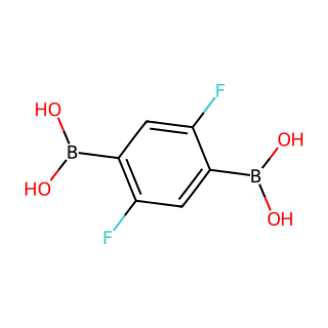

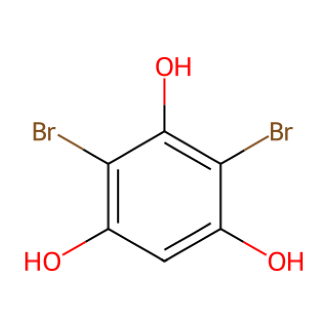

(None, None)

In [6]:
show_mol(molA),show_mol(molB)

Above are the image representations of the monomer molecules.

Now certain portion of the molecules will be removed while forming the polymer chain. The "B(O)O" sections of the monomer A will be removed exposing a connection to adjacent monomer. Similarly "Br" sections of the monomer B will be removed.

The parts that will be removed for both monomers are notified in following images for each monomer respectively.

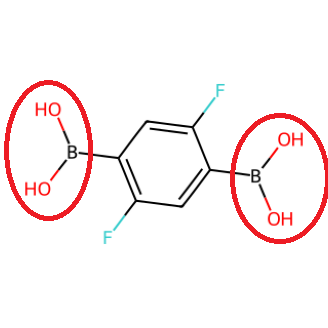

In [8]:
from IPython.display import Image
Image('./assets/polymer_images/monoA.png')

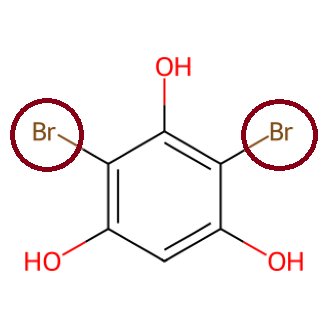

In [ ]:
Image('/content/drive/MyDrive/gsoc_inputs/dataset_vipea/monoB.png')

Let's consider the monomers connect at the given site than a sample resultant repeating molecule will be as follows.

MonomerAB = Atc1cc(F)c(c1c(O)c(At)c(O)cc1(O))c(o)c1(F)

where "At" represents the previous and next molecule in the polymer chain.

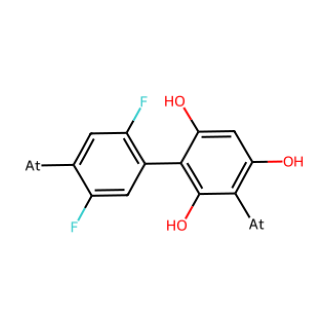

In [9]:
mAB = "[At]c1cc(F)c(c2c(O)c([At])c(O)cc2(O))cc1(F)"
molAB = Chem.MolFromSmiles(mAB)
print(molAB)
show_mol(molAB)

Now the previous monomer and next monomer will be attatched to the "At" section of the resultant monomer AB.

With our chemistry knowledge of SMILES we were able to decode the resultant SMILES.

**But how can we emulate the process programmatically so that we can replicate the process with similar monomers where "B(O)O" and "Br" bonds are broken to form the polymer chain ????**

## 2. Programmatic Conversion <a class="anchor" id="progconv"></a>

In this section we will see how we can programmatically convert molecules containing "B(O)O" and "Br" functional groups to detect open bonds for polymer representation.

**We will be using SMILES arbitrary target specification (SMARTS) to emulate the reaction and detect partterns in the molecules.**

In [10]:
from rdkit.Chem import AllChem

We will convert the molecule representation in SMARTS format in 2 steps

1. Converting B(O)O to open bonds
2. Converting Br to open bonds
3. Indexing the generated open bonds

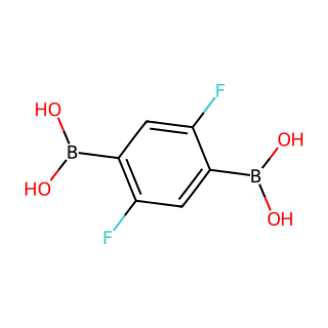

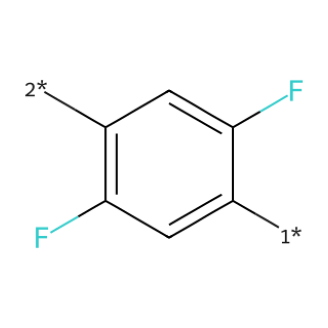

In [12]:
def remove_duplicate_molecules(mols):
  '''
  This function is to remove duplicate molecules that are generated during
  the chemical reaction.
  Returns only the unique product molecules.
  '''
  smiles = list(set([Chem.MolToSmiles(m, canonical=True) for m in mols]))
  mols = [Chem.MolFromSmiles(s) for s in smiles]
  return mols

# there are potential two open bonds in our monomer A
molA_s = molA
for i in [1,2]:
  smarts = f"[*:1]([B](-O)(-O))>>[*:1]-[*{i}]" # SMARTS to emulate reaction of B(O)O to open bond
  reaction = AllChem.ReactionFromSmarts(smarts)
  resultants = reaction.RunReactants((molA_s,))
  products = remove_duplicate_molecules([r[0] for r in resultants])
  molA_s = products[0]  # getting the main product of the reaction

show_mol(molA)
show_mol(molA_s)

Now we can see the "B(O)O" section converting to an open bond with index.

We will convert the molecule to smiles and do some further modifications before storing it as a string value.

In [13]:
molA_s_smiles = Chem.MolToSmiles(molA_s, canonical=True)
print(molA_s_smiles)

[1*]c1cc(F)c([2*])cc1F


In [14]:
# converting the SMILES to SMARTS notation
molA_s_smiles = molA_s_smiles.replace("*1","*:1").replace("*2","*:2")
print(molA_s_smiles)

[1*]c1cc(F)c([2*])cc1F


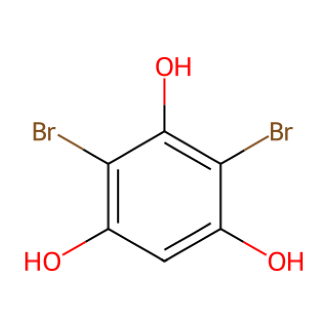

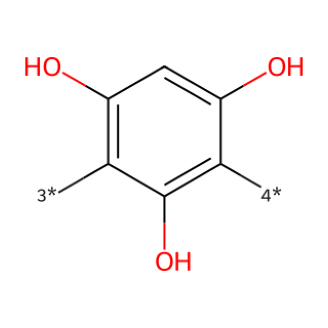

In [15]:
# there are potential two open bonds in our monomer B
molB_s = molB
for i in [3,4]:
  smarts = f"[*:1]Br>>[*:1]-[*{i}]" # SMARTS to emulate reaction of Br to open bond
  reaction = AllChem.ReactionFromSmarts(smarts)
  resultants = reaction.RunReactants((molB_s,))
  products = remove_duplicate_molecules([r[0] for r in resultants])
  molB_s = products[0]  # getting the main product of the reaction

show_mol(molB)
show_mol(molB_s)

In [18]:
molB_s_smiles = Chem.MolToSmiles(molB_s, canonical=True)
print(molB_s_smiles)
# converting the SMILES to SMARTS notation
molB_s_smiles = molB_s_smiles.replace("*1","*:1").replace("*2","*:2")
print(molB_s_smiles)

[3*]c1c(O)cc(O)c([4*])c1O
[3*]c1c(O)cc(O)c([4*])c1O


### Conversion Considerations <a class="anchor" id="convConsid"></a>

* We considered B(O)O and Br as the functional group that breaks for polymer chain propagation.
* But for real world polymers, we can have a very high number of functional groups.
* For our usecase we have collected the database of only polymers that contain B(O)O and Br as breaking point of polymer chain propagation.

Yet the above approach has one problem to be resolved.
- The SMARTS pattern that replaces Br in this example is connected with the aromatic carbon atom.
- While in other monomer there could be a Br that is conneted to an aliphatic carbon. (Like the below example)

In [19]:
smile_eg = "Oc1c(Br)cc(Br)cc1CBr"

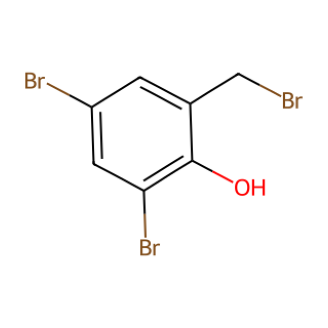

In [20]:
eg_mol = Chem.MolFromSmiles(smile_eg)
show_mol(eg_mol)

Now if we go with the same process of conversion, we get following result.

In [21]:
eg_mol_s = eg_mol
for i in [3,4,5]: # as there are 3 Br
  smarts = f"[*:1]Br>>[*:1]-[*{i}]" # SMARTS to emulate reaction of Br to open bond
  reaction = AllChem.ReactionFromSmarts(smarts)
  resultants = reaction.RunReactants((eg_mol_s,))
  products = remove_duplicate_molecules([r[0] for r in resultants])
  eg_mol_s = products[0]  # getting the main product of the reaction

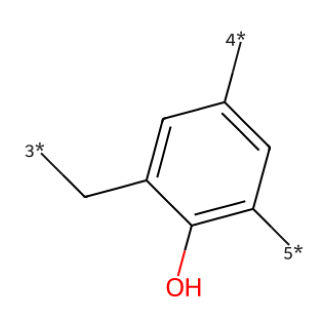

In [22]:
show_mol(eg_mol_s)

Now according to the process the chain will connect at *3 and *4 only while we should not be excluding the Br at *5.

To fix this issue
- We will convert the Br connected with aliphatic carbon (CBr) to a virtual atom.
- Do the operation with the modified molecule.
- Restore the virtual atom to Br.

In [24]:
def CBr_to_At(mol):
    while mol.HasSubstructMatch(Chem.MolFromSmarts('cCBr')):
        smarts = "[*:1]CBr>>[*:1]C[At]" # converts CBr to At
        reactions = AllChem.ReactionFromSmarts(smarts)
        resultant = reactions.RunReactants((mol,))
        products = remove_duplicate_molecules([r[0] for r in resultant])
        mol = products[0]
    return mol

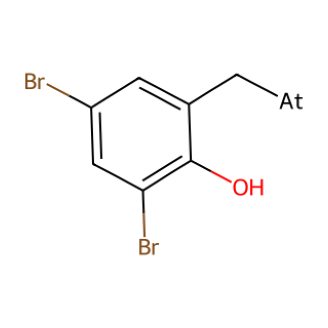

In [25]:
eg_mol_v = CBr_to_At(eg_mol)
show_mol(eg_mol_v)

Now making the conversion

Now only 2 Br is left that will be used for chain propagation.

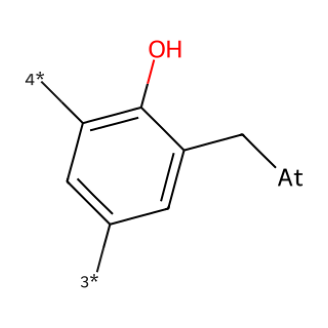

In [27]:
eg_mol_s = eg_mol_v
for i in [3,4]: # Now there are two Br that wil break for open bond
  smarts = f"[*:1]Br>>[*:1]-[*{i}]" # SMARTS to emulate reaction of Br to open bond
  reaction = AllChem.ReactionFromSmarts(smarts)
  resultants = reaction.RunReactants((eg_mol_s,))
  products = remove_duplicate_molecules([r[0] for r in resultants])
  eg_mol_s = products[0]  # getting the main product of the reaction

show_mol(eg_mol_s)

To retrieve the actual atom we are replacing the virtual atom with Br.

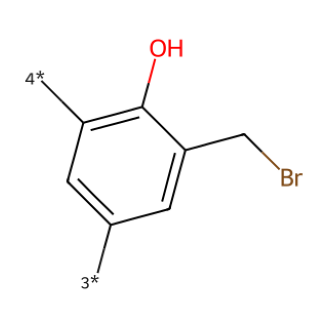

In [28]:
def At_to_CBr(mol):
    while mol.HasSubstructMatch(Chem.MolFromSmarts('C[At]')):
        smarts = "[*:1]C[At]>>[*:1]CBr"
        reactions = AllChem.ReactionFromSmarts(smarts)
        resultants = reactions.RunReactants((mol,))
        products = remove_duplicate_molecules([r[0] for r in resultants])
        mol = products[0]
    return mol

eg_mol_final = At_to_CBr(eg_mol_s)
show_mol(eg_mol_final)

In this way we can make sure that only relevant Br atoms are removed to denote the connecting bonds.

## 3. Data Aggregation <a class="anchor" id="dataAgg "></a>

At our initial introduction, we connected open bond at index 2 of monomer A with open bond at index 3 of monomer B.

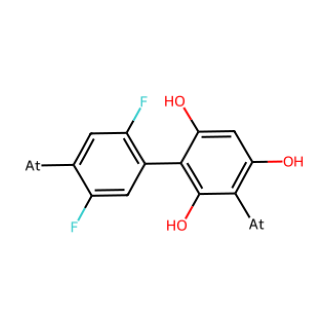

In [30]:
from IPython.display import Image
Image('./assets/polymer_images/sample.png')

But this representation lacks 2 very important aspects !
1. What fractions of monomer is considered !
2. Which monomer is connected at which index of open bonds !

### Determining Fractions

Determining fractions of monomer contributing to the whole of the polymer is usually deterministic.

- As we have collected a specific dataset the monomers of defined fraction contributes to the whole monomer.

- In our dataset we have 3 set of fraction variations i.e. 1:3, 1:1, 3:1.

- To represent these variations we are using float values.

  1. 1:3 -> 0.25: 0.75
  2. 3:1 -> 0.75: 0.25
  3. 1:1 -> 0.50: 0.50

- The alternating polymer have a constant fraction of 1:1. So for alternating polymer the fraction will be 0.5 only. For other polymer types there could be a combination of above fractions.

### Determining Connections

The connection between monomers are determined based on following factors.

1. Connection sites available at each monomer
2. The stoichiometry type of the polymer.
3. The capacity of the monomer to connect with same monomer at same sites. (self edge)

- As we have collected a specific dataset each monomer have 2 connections site each.

- The connection site at monomer A is labeled as 1 and 2 while the connection site at monomer B is labeled as 3 and 4.

The polymer stochiometry has different types. We considered 3 of it for our usecase.

1. Alternating
2. Block
3. Random

For each stochiometry the probability of connection is calculated differently.

- For alternating type the self edge is not considered and the probability of connection is 0.5 for each connection site.

- For block type the probability calculation is interesting.
  - For block polymer the monomers are arranged something like this : AAAABBBB

  - So there are 2 kind of connections.
  i.e. Homogenous (Link between same kind of monomers > A-A or B-B) and Heterogeneous (Link between different kind of monomers > A-B or B-A)

  - As we have taken monomers of similar ratios of 1:1, 3:1, and 1:3, a 8-monomer combination will depict the process easier.

  - Lets consider AAAABBBB: In this example the connection between A and B occures once between 8 atoms hence the heterogeneous connections (1-3, 2-3, 1,-4, 2-4) has a probability of connection of 1/8.

  - Similarly the homogeneous connections occure in 6 atoms (1-2, 3-4) contributing the probability of connection to 6/8.

  - Again if we consider the self edges the connection between atoms can happen at both the open bonds. Hence modifying the probability to 3/8 for (1-2,2-2,1-1, 3-3,3-4,4-4)


- For random copolymers the weight / probability calculation is even simpler.

  - If we consider self edges each open bond can connect with 1 one of 4 open bonds of another monomer. Hence the probability will remain 1/4 for every connection.

  - Without self edges the open bonds of each monomer connects only to altenate open bond of another monomer of same class. Hence bonds like 1-2 and 3-4 have a probability of 0.5 while other bonds remain at probability of 0.25.

### Determining Fractions and Connections using the code.

We have to programmatically depict this procedure to output a string containing all these details.

- For fractions, we enclose and separate individual fractions with "|".

In [32]:
# for monomer A and monomer B the fractions is 1:1
fracA = 0.5
fracB = 1-0.5

frac_output = f"|{fracA}|{fracB}|"
print(frac_output)

|0.5|0.5|


- For stoichiometry, we create at most 3 variations. (for alternate, block, and random)

- for each variation we seprate each bond with their corresponding weight with "<" character.

- for separation of bond index and weights we have used ":"

- **As we will be using weighted directed graphs, even if the weight is duplicated for each bond and it's alternate, we kept the weights separated.**

In [33]:
# for alternating no self edge is possible
alt_edges = "<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5"
# in above example the bond connecting open bond at 1 and 3 has the weight 0.5 while the direction of bond 3 connecting with bond 1 has the weight of 0.5.

In [34]:
# for block copolymer with self edges
block_edge_content = [(1, 2, 3/8, 3/8),  # within A
        (1, 1, 3/8, 3/8),
        (2, 2, 3/8, 3/8),
        (3, 4, 3/8, 3/8),  # within B
        (3, 3, 3/8, 3/8),
        (4, 4, 1/8, 1/8),
        (1, 3, 1/8, 1/8),  # between A and B
        (1, 4, 1/8, 1/8),
        (2, 3, 1/8, 1/8),
        (2, 4, 1/8, 1/8)]
block_edges = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in block_edge_content])
print(block_edges)

<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


In [35]:
# for block copolymer with no self edges
block_edge_content = [(1, 2, 6/8, 6/8),  # within A
                     (3, 4, 6/8, 6/8),  # within B
                     (1, 3, 1/8, 1/8),  # between A and B
                     (1, 4, 1/8, 1/8),
                     (2, 3, 1/8, 1/8),
                     (2, 4, 1/8, 1/8)]
block_no_self_edges = "".join([f"<{e[0]}-{e[1]}:{e[2]}:{e[3]}" for e in block_edge_content])
print(block_no_self_edges)

<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


In [36]:
# for random copolymer with self edges
random_self_edges = '<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.25:0.25<3-4:0.25:0.25<1-1:0.25:0.25<2-2:0.25:0.25<3-3:0.25:0.25<4-4:0.25:0.25'
# for random copolymer without self edges
random_edges = '<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.5:0.5<3-4:0.5:0.5'

## 4. Data Finalization <a class="anchor" id="dataFinal"></a>

In this section, we will simply combine the monomer representation with open bonds with monomer fractions and weigth distribution along edges into a single string value.

In [39]:
mol_data_pre = f"{molA_s_smiles}.{molB_s_smiles}|{fracA}|{fracB}|"
print(mol_data_pre)

[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|


We combined two monomers with a separator of "." as it's a valid expression for smiles to combinely represent molecules with "." in between. (Refer to the code below)

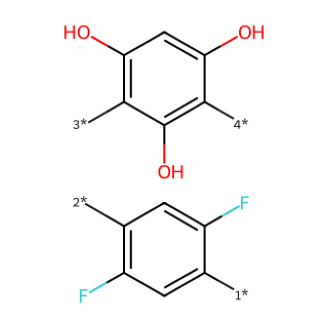

In [37]:
smart_pattern = f"{molA_s_smiles}.{molB_s_smiles}"
show_mol(Chem.MolFromSmiles(smart_pattern))

Now we combine weight distribution string for all the stoichiometry type in case of self edges and no self edges.

In [40]:
alt_input = mol_data_pre+alt_edges # alt edges has no variation for self edge connection
# for self edges
random_self_input = mol_data_pre+random_self_edges
block_self_input = mol_data_pre+block_edges

# for non self edges

random_input = mol_data_pre+random_edges
block_input = mol_data_pre+block_no_self_edges

As the the initial parameter will be specified to include the self edges or not, there could be 3 variations of polymer representation from monomer molecules.

In [41]:
# for self edges
print(alt_input)
print(random_self_input)
print(block_self_input)

[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5
[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.25:0.25<3-4:0.25:0.25<1-1:0.25:0.25<2-2:0.25:0.25<3-3:0.25:0.25<4-4:0.25:0.25
[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.375:0.375<1-1:0.375:0.375<2-2:0.375:0.375<3-4:0.375:0.375<3-3:0.375:0.375<4-4:0.125:0.125<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


In [42]:
# for no self edges
print(alt_input)
print(random_input)
print(block_input)

[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-3:0.5:0.5<1-4:0.5:0.5<2-3:0.5:0.5<2-4:0.5:0.5
[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-3:0.25:0.25<1-4:0.25:0.25<2-3:0.25:0.25<2-4:0.25:0.25<1-2:0.5:0.5<3-4:0.5:0.5
[1*]c1cc(F)c([2*])cc1F.[3*]c1c(O)cc(O)c([4*])c1O|0.5|0.5|<1-2:0.75:0.75<3-4:0.75:0.75<1-3:0.125:0.125<1-4:0.125:0.125<2-3:0.125:0.125<2-4:0.125:0.125


The provided string format defines the core representation for polymer graphs used for storage and retrieval within this system. It's important to note that the conversion process from a monomer's inherent details (such as potential open bond locations and edge weight distributions) into this string format can differ based on the specific monomer. As a result, users are responsible for developing tailored conversion functions to convert their monomer data into above format.

In the context of our curated dataset, the described conversion method efficiently transforms individual monomer SMILES strings into a standardized string representation. This representation encapsulates annotations for open bonding sites, the fractional composition of each monomer type within the polymer, and the weight distributions along connected edges within the polymer graph.


In our next section we will discuss the process of visualizing the graph out of this string representation.

## 5. Graph Visualization <a class="anchor" id="dataVis"></a>

The visualization of molecules as graphs is a well-established technique in this context. Our approach leverages this technique by first converting the constituent atoms of each monomer into graph nodes and the chemical bonds between them into edges. In this initial phase, all edges are assigned a weight of 1.

The second phase focuses on incorporating the information about connected edges stored within the string representation. By parsing this data, we identify and introduce additional edges that explicitly connect the open bonding sites of the monomers. These newly introduced edges are not present in the initial graph representation and are assigned weights that correspond to the respective fractional values associated with each edge in the string format.

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem

# creating colour mapping for different atoms
COLOR_MAPPER ={
    "C" : "green",
    "F" : "blue" ,
    "O" : "yellow"
}


def rev_bonds(bond_str):
  """creates reverse bonds of the existing bonds between open bonds"""
  rev_str = str(bond_str.split("-")[-1])+"-"+str(bond_str.split("-")[0])
  return rev_str


def smiles_to_graph(smiles_string):
    """Converts a SMILES string to a weighted, directed NetworkX graph."""

    # Split the SMILES string by the pipe (|) delimiter
    parts = smiles_string.split('|')
    node_colors = []

    # Extract the SMILES representation of monomers (before the pipe)
    monomer_smiles = parts[0]

    # Extracting connection bond details from string representation
    bonds_strs= parts[-1].split("<")[1:]

    # creating dictionary of bonds in both directions
    bond_dict={ k.split(":")[0]: k.split(":")[1] for k in bonds_strs }
    rev_bond_dict={ rev_bonds(bond_val):bond_wei for (bond_val,bond_wei) in bond_dict.items() }
    bond_dict.update(rev_bond_dict)

    node_labels = {}

    # Create an empty directed graph
    G = nx.DiGraph()

    # Process the monomer SMILES string using RDKit
    mol = Chem.MolFromSmiles(monomer_smiles)
    atoms = mol.GetAtoms()

    updater = 1

    # Add nodes to the graph based on atom indices
    for atom in atoms:
      if (atom.GetSymbol() == "*"):
        # adding wild card atoms and assigning labels with it
        G.add_node(atom.GetIdx())
        node_labels[atom.GetIdx()] = f"*{updater}"
        node_colors.append("gray")
        updater += 1
      else:
        G.add_node(atom.GetIdx())
        node_labels[atom.GetIdx()] = f"{atom.GetSymbol()}"
        node_colors.append(COLOR_MAPPER[f"{atom.GetSymbol()}"])



    # Process edges (bonds) and weights
    for bond in mol.GetBonds():
        source = bond.GetBeginAtomIdx()
        target = bond.GetEndAtomIdx()
        G.add_edge(source, target, weight=1.0, label="1.0")
        G.add_edge(target, source, weight=1.0, label="1.0")

    # assigning new connected edges to the graph
    for bond_val, wei_val in bond_dict.items():
      start = "*"+bond_val.split("-")[0]
      end = "*"+bond_val.split("-")[1]
      start_idx, end_idx = None,None
      for idx,val in node_labels.items():
        if val == start:
          start_idx = idx
        elif val == end:
          end_idx = idx
      # handling self edge case
      if start == end and start != None:
        G.add_edge(start_idx,start_idx, weight=wei_val, label=f"{wei_val}")
      else:
        if start_idx == None: raise ValueError(f"Index not found for start wildcard {start}")
        if end_idx == None: raise ValueError(f"Index not found for end wildcard {end}")
        G.add_edge(start_idx,end_idx, weight=wei_val, label=f"{wei_val}")


    return G,node_labels, node_colors


def draw_graph(smiles_string):
  """This function draws the graph with edge-labels and colors"""
  G, node_labels, node_colors  = smiles_to_graph(smiles_string)

  plt.figure(figsize=(10,10))
  # Create visual representation using Matplotlib and NetworkX
  pos = nx.spring_layout(G)  # Use a layout algorithm
  # node_labels = {node: node for node in G.nodes()}

  # Customize edge labels to display weights
  edge_labels = {(source, target): data['label'] for source, target, data in G.edges.data()}

  nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_shape='o')
  nx.draw_networkx_edges(G, pos, edgelist=G.edges(), arrows=True, width=2, alpha=0.7, edge_color="black")
  nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

  plt.axis('off')
  plt.show()

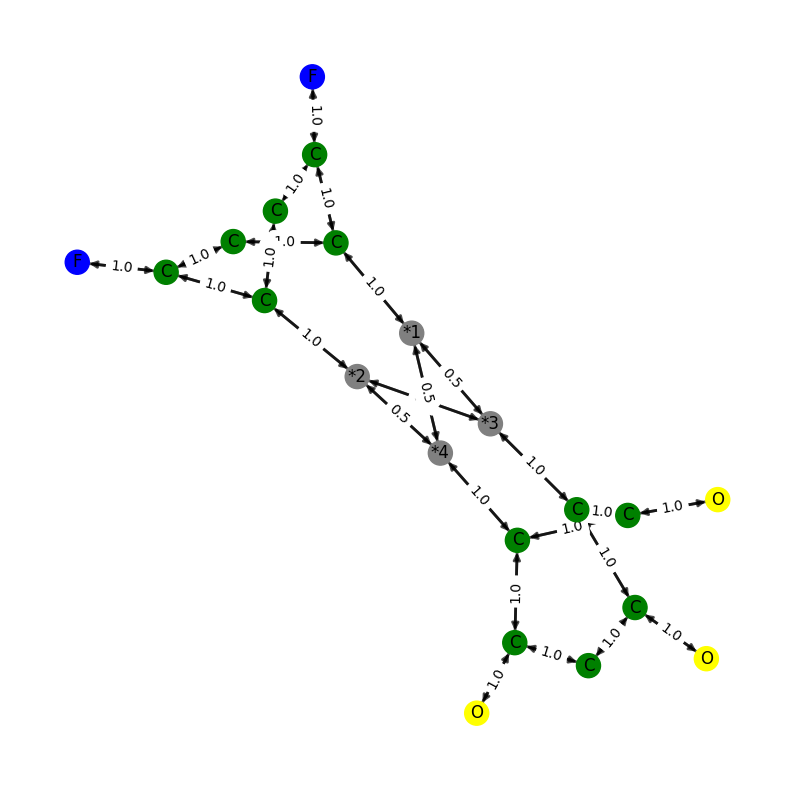

In [44]:
draw_graph(alt_input)

In the aforementioned example of the polymer representation, weights are assigned to open bonds based on a probability distribution. These weighted open bonds are visually represented by distinct nodes colored in gray, which are interconnected by bidirectional edges. It's crucial to emphasize that this specific visualization portrays a non-self edged alternating copolymer.

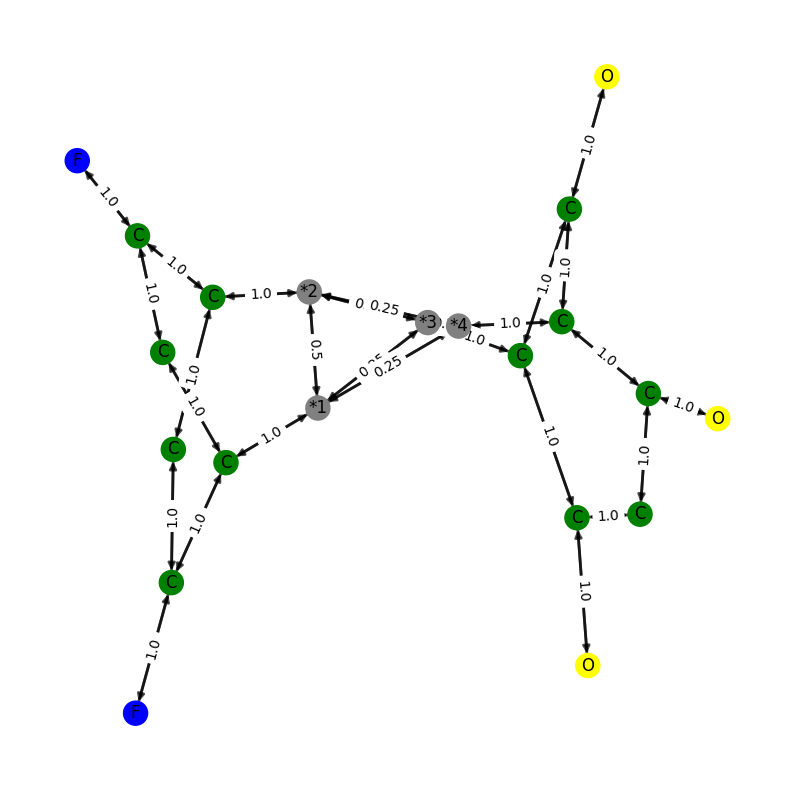

In [45]:
draw_graph(random_input)

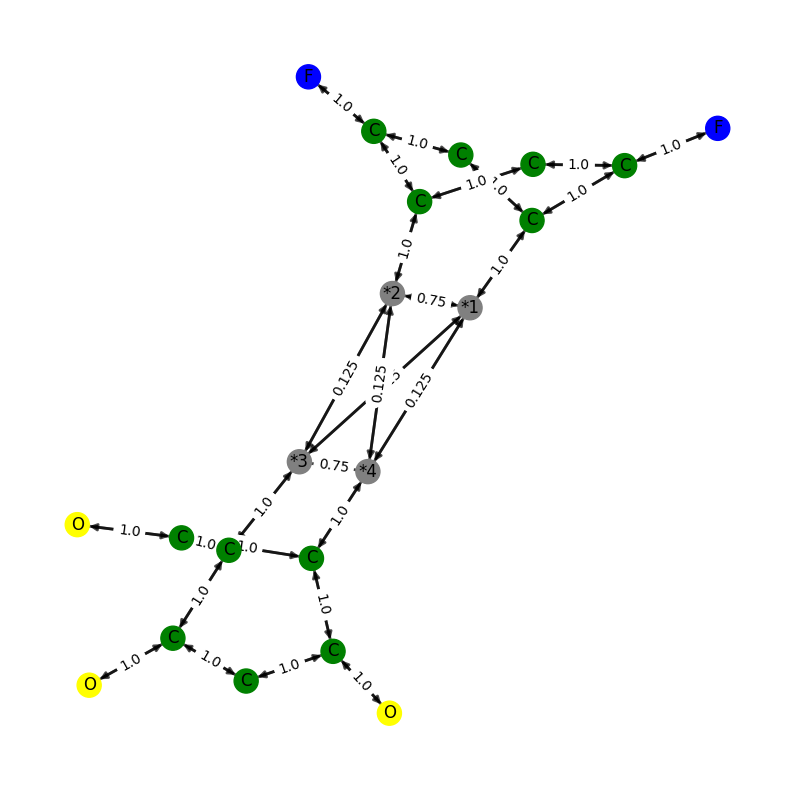

In [46]:
draw_graph(block_input)

For block and random copolymer, the weight distribution along open bond connections changes while the struture remains same.

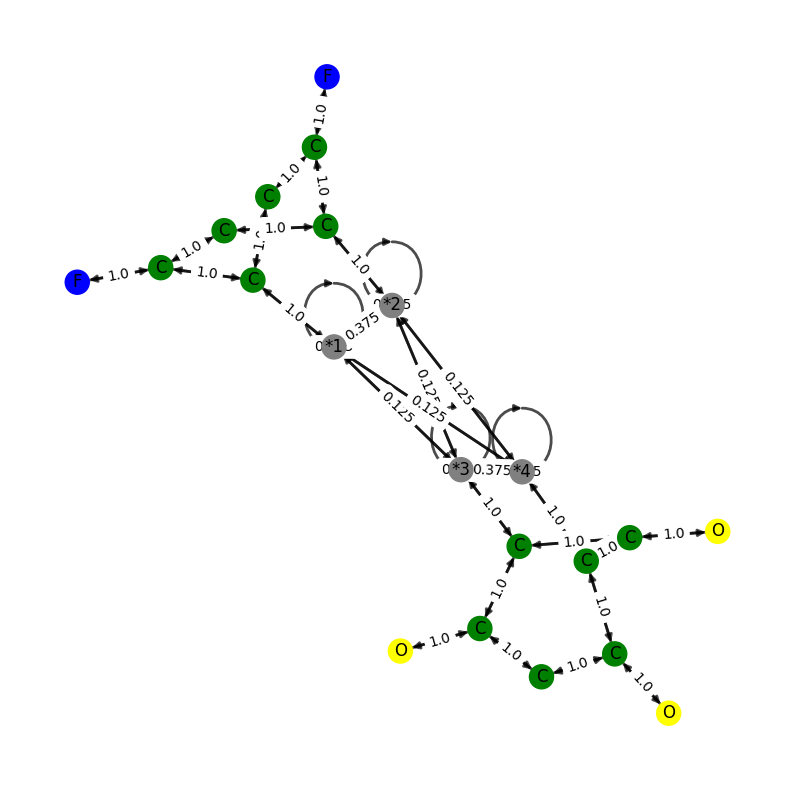

In [48]:
draw_graph(block_self_input)

For self-edged copolymers extra 4 edges are added to represent the connection between the open bonds itself

While the current string format facilitates the visualization of the polymer graph, it is not directly usable by neural networks. Neural network models require their input data to be represented as numerical vectors. Therefore, we need to employ featurization to convert the information encoded within the string representation into a suitable numerical vector format that can be effectively processed by the neural network.

## 6. Featurization <a class="anchor" id="feat "></a>

In order to create different feature vectors out of string representation following steps are followed.
1. Include atom data and separate bond data as metadata
  - Including the monomer fraction as property of corresponding atoms
  - Separating repeating unit bond details
  - Assigning metadata to define core and non-core atoms
  - Assigning metadata to define the index for non-core atoms
2. Remove the wildcard atoms
3. Initializing empty vectors for following values
  - Featurized Atom Vector (one-hot encoding)
  - Weight Mapping for Atom Vector (Fraction of the monomer)
  - Featurized Bond Vector (one-hot-encoding)
  - Weight Mapping for Bond Vector (Probability Weight Fraction)
  - Mapping Array for atoms to bonds
  - Mapping Array for bonds to atoms
  - Mapping Array for bonds to reverse bonds
4. Assigning Values to Vectors
  - Iterating Through Atoms and Assigning atom feature vectors and corresponding weights
  - Iterating Through Bonds within Monomers
    - Featurize the bond and concatenate vector with connected atom feature vector
    - Update the mapping indexes in mapping arrray
  - Iterating Through Bonds within repeating units
    - Duplicate and Combine Existing Monomer Molecules
    - Iterate through separate unit bond details
      - Use the metadata to identify the bond types and map the weight
      - Create and Concatentate bond features (with atom feature vector) based on the metadata
      - Modify the Weight Mapping for Created bonds
      - Remove the Duplicated Bonds after operation
    - Update the Mapping Arrays

Let's Code

In [49]:
def make_mol(s: str, keep_h: bool, add_h: bool):
    """
    Builds an RDKit molecule from a SMILES string.
    """
    if keep_h:
        mol = Chem.MolFromSmiles(s, sanitize = False)
        Chem.SanitizeMol(mol, sanitizeOps = Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_ADJUSTHS)
    else:
        mol = Chem.MolFromSmiles(s)
    if add_h:
        mol = Chem.AddHs(mol)
    return mol


def make_polymer_mol(smiles: str, keep_h: bool, add_h: bool, fragment_weights: list):
    """
    Builds an RDKit molecule from a SMILES string.
    """

    # check input is correct, we need the same number of fragments and their weights
    num_frags = len(smiles.split('.'))
    if len(fragment_weights) != num_frags:
        raise ValueError(f'number of input monomers/fragments ({num_frags}) does not match number of '
                         f'input number of weights ({len(fragment_weights)})')

    # if it all looks good, we create one molecule object per fragment, add the weight as property
    # of each atom, and merge fragments into a single molecule object
    mols = []
    for s, w in zip(smiles.split('.'), fragment_weights):
        m = make_mol(s, keep_h, add_h)
        for a in m.GetAtoms():
            a.SetDoubleProp('w_frag', float(w)) # assinging metadata to store the weight fragment of the monomer
        mols.append(m)

    # combine all mols into single mol object
    mol = mols.pop(0)
    while len(mols) > 0:
        m2 = mols.pop(0)
        mol = Chem.CombineMols(mol, m2)

    return mol

In [50]:
from rdkit import Chem

The make molecule function basically handles the Hydrogen molecules according to the user requirement and returns a modified molecule.

In [51]:
s = "C([H])=O"
mol = make_mol(s,keep_h = True, add_h = True)
mol.GetNumAtoms()

4

In this example we can see that if we keep hydrogen and add hydrogen accoding to SMILES we get 4 number of atoms.

In [52]:
s = "C([H])=O"
mol = make_mol(s,keep_h = False, add_h = True)
mol.GetNumAtoms()

4

Now even if we keep_h false still add_h enables addition of required hydrogen and balances the atom to 4 again.

In [53]:
s = "C([H])=O"
mol = make_mol(s,keep_h = True, add_h = False)
mol.GetNumAtoms()

3

In above case the addition of Hydrogen is restricted by setting add_h to false hence it considers only the given Hydrogen in the SMILES.

In [54]:
s = "C([H])=O"
mol = make_mol(s,keep_h = False, add_h = False)
mol.GetNumAtoms()

2

Now by keeping add_h and keep_h to false we get only oxygen and carbon hence keeping the number of atoms only to 2.

For a simpler example we can take methane (CH4) molecule.

5


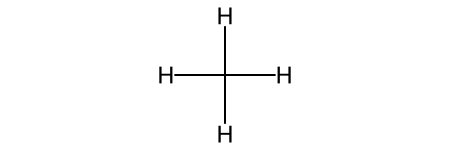

In [55]:
mol = make_mol("C", keep_h= True, add_h= True)
print(mol.GetNumAtoms())
mol

The `make_polymer_mol` function is responsible for extracting the string representation of the polymer and adding those as metadata to the polymer molecule.

In [56]:
test_mol = "[1*]C.C[2*]|0.5|0.5|<1-2:0.5:0.5"

In [57]:
poly_mol = make_polymer_mol(test_mol.split("|")[0], keep_h=False, add_h=False,fragment_weights=test_mol.split("|")[1:-1])
for a in make_polymer_mol(test_mol.split("|")[0], keep_h=False, add_h=False, fragment_weights =test_mol.split("|")[1:-1]).GetAtoms():
  print(a.GetDoubleProp('w_frag'))

0.5
0.5
0.5
0.5


The code above checks the monomer fractions of the fragments are assigned to each atom.

In [58]:
mol = (poly_mol,test_mol.split("<")[1:])

We require to collect the end section of the string representation and parse it to create tuples of bond data with probability as it's weights. That's exactly what following function `parse_polymer_rules` does.

In [60]:
from collections import Counter
import numpy as np
def parse_polymer_rules(rules):
    """
    converting probabilty weight distribution details from string to list of tuples to (start, end, weight_forward, weight_reverse)
    """
    polymer_info = []
    counter = Counter()  # used for validating the input

    # check if deg of polymerization is provided
    if '~' in rules[-1]:
        Xn = float(rules[-1].split('~')[1])
        rules[-1] = rules[-1].split('~')[0]
    else:
        Xn = 1.

    for rule in rules:
        # handle edge case where we have no rules, and rule is empty string
        if rule == "":
            continue
        # QC of input string
        if len(rule.split(':')) != 3:
            raise ValueError(f'incorrect format for input information "{rule}"')
        idx1, idx2 = rule.split(':')[0].split('-')
        w12 = float(rule.split(':')[1])  # weight for bond R_idx1 -> R_idx2
        w21 = float(rule.split(':')[2])  # weight for bond R_idx2 -> R_idx1
        polymer_info.append((idx1, idx2, w12, w21))
        counter[idx1] += float(w21)
        counter[idx2] += float(w12)

    # validate input: sum of incoming weights should be one for each vertex
    for k, v in counter.items():
        if np.isclose(v, 1.0) is False:
            raise ValueError(f'sum of weights of incoming stochastic edges should be 1 -- found {v} for [*:{k}]')
    return polymer_info, 1. + np.log10(Xn)

In order to keep a valid SMILES representation and open bonds we need to replace the wildcards and assign additional properties to bonds to denote the open or core bonds, and the wildcard notation that denotes the index of the open bond. The function `tag_atoms_in_repeating_unit` assigns a boolean property to denote core or non core bonds along with it, it sets the 'R' property with the index of the open bond when required to denote the wildcard atoms.

In [61]:
def tag_atoms_in_repeating_unit(mol):
    """
    Tags atoms that are part of the core units, as well as atoms serving to identify attachment points. In addition,
    create a map of bond types based on what bonds are connected to R groups in the input.
    """
    atoms = [a for a in mol.GetAtoms()]
    neighbor_map = {}  # map R group to index of atom it is attached to
    r_bond_types = {}  # map R group to bond type

    # go through each atoms and: (i) get index of attachment atoms, (ii) tag all non-R atoms
    for atom in atoms:
        # if R atom
        if '*' in atom.GetSmarts():
            # get index of atom it is attached to
            neighbors = atom.GetNeighbors()
            assert len(neighbors) == 1
            neighbor_idx = neighbors[0].GetIdx()
            r_tag = atom.GetSmarts().strip('[]').replace(':', '')  # *1, *2, ...
            neighbor_map[r_tag] = neighbor_idx
            # tag it as non-core atom
            atom.SetBoolProp('core', False)
            # create a map R --> bond type
            bond = mol.GetBondBetweenAtoms(atom.GetIdx(), neighbor_idx)
            r_bond_types[r_tag] = bond.GetBondType()
        # if not R atom
        else:
            # tag it as core atom
            atom.SetBoolProp('core', True)

    # use the map created to tag attachment atoms
    for atom in atoms:
        if atom.GetIdx() in neighbor_map.values():
            r_tags = [k for k, v in neighbor_map.items() if v == atom.GetIdx()]
            atom.SetProp('R', ''.join(r_tags))
        else:
            atom.SetProp('R', '')

    return mol, r_bond_types

Once the information associated with the wildcard is aligned with a valid smile we should be removing the wildcard atom notations. The following function `remove_wildcard_atoms` does it and balances the molecule after removing the wildcard atoms.

In [62]:
def remove_wildcard_atoms(rwmol):
  """Removes the connection virtual atoms for open bonds"""
  indices = [a.GetIdx() for a in rwmol.GetAtoms() if '*' in a.GetSmarts()]
  while len(indices) > 0:
      rwmol.RemoveAtom(indices[0])
      indices = [a.GetIdx() for a in rwmol.GetAtoms() if '*' in a.GetSmarts()]
  Chem.SanitizeMol(rwmol, Chem.SanitizeFlags.SANITIZE_ALL)
  return rwmol

In [63]:
class Featurization_parameters:
    """
    A class holding standard molecule featurization parameters as attributes.
    """
    def __init__(self) -> None:

        # Atom feature sizes
        self.MAX_ATOMIC_NUM = 100
        self.ATOM_FEATURES = {
            'atomic_num': list(range(self.MAX_ATOMIC_NUM)),
            'degree': [0, 1, 2, 3, 4, 5],
            'formal_charge': [-1, -2, 1, 2, 0],
            'chiral_tag': [0, 1, 2, 3],
            'num_Hs': [0, 1, 2, 3, 4],
            'hybridization': [
                Chem.rdchem.HybridizationType.SP,
                Chem.rdchem.HybridizationType.SP2,
                Chem.rdchem.HybridizationType.SP3,
                Chem.rdchem.HybridizationType.SP3D,
                Chem.rdchem.HybridizationType.SP3D2
            ],
        }

        # Distance feature sizes
        self.PATH_DISTANCE_BINS = list(range(10))
        self.THREE_D_DISTANCE_MAX = 20
        self.THREE_D_DISTANCE_STEP = 1
        self.THREE_D_DISTANCE_BINS = list(range(0, self.THREE_D_DISTANCE_MAX + 1, self.THREE_D_DISTANCE_STEP))

        # len(choices) + 1 to include room for uncommon values; + 2 at end for IsAromatic and mass
        self.ATOM_FDIM = sum(len(choices) + 1 for choices in self.ATOM_FEATURES.values()) + 2
        self.EXTRA_ATOM_FDIM = 0
        self.BOND_FDIM = 14
        self.EXTRA_BOND_FDIM = 0
        self.REACTION_MODE = None
        self.EXPLICIT_H = False
        self.REACTION = False
        self.POLYMER = False
        self.ADDING_H = False

# Create a global parameter object for reference throughout this module
PARAMS = Featurization_parameters()

The class above holds all the parameters required to featurize an atom or bond and form a vector.

In [64]:
def onek_encoding_unk(value: int, choices):
    """
    Creates a one-hot encoding with an extra category for uncommon values.
    """
    encoding = [0] * (len(choices) + 1)
    index = choices.index(value) if value in choices else -1
    encoding[index] = 1

    return encoding

In [65]:
onek_encoding_unk(69, [1, 2, 3])

[0, 0, 0, 1]

The `onek_encoding_unk` function creates one hot encoding vector while keeping the unkown values as a binary column at the end. (As you can see the example above)

Now all we need is to use the featurization parameters and one hot encoding to generate relevant vectors. The functions below `atom_features` and `bond_features` do exactly that.

In [66]:
def atom_features(atom: Chem.rdchem.Atom, PARAMS: Featurization_parameters, functional_groups = None):
    """
    Builds a feature vector for an atom.
    """
    if atom is None:
        features = [0] * PARAMS.ATOM_FDIM
    else:
        features = onek_encoding_unk(atom.GetAtomicNum() - 1, PARAMS.ATOM_FEATURES['atomic_num']) + \
            onek_encoding_unk(atom.GetTotalDegree(), PARAMS.ATOM_FEATURES['degree']) + \
            onek_encoding_unk(atom.GetFormalCharge(), PARAMS.ATOM_FEATURES['formal_charge']) + \
            onek_encoding_unk(int(atom.GetChiralTag()), PARAMS.ATOM_FEATURES['chiral_tag']) + \
            onek_encoding_unk(int(atom.GetTotalNumHs()), PARAMS.ATOM_FEATURES['num_Hs']) + \
            onek_encoding_unk(int(atom.GetHybridization()), PARAMS.ATOM_FEATURES['hybridization']) + \
            [1 if atom.GetIsAromatic() else 0] + \
            [atom.GetMass() * 0.01]  # scaled to about the same range as other features
        if functional_groups is not None:
            features += functional_groups
    return features

def bond_features(bond: Chem.rdchem.Bond, PARAMS: Featurization_parameters):
    """
    Builds a feature vector for a bond.
    """
    if bond is None:
        fbond = [1] + [0] * (PARAMS.BOND_FDIM - 1)
    else:
        bt = bond.GetBondType()
        fbond = [
            0,  # bond is not None
            bt == Chem.rdchem.BondType.SINGLE,
            bt == Chem.rdchem.BondType.DOUBLE,
            bt == Chem.rdchem.BondType.TRIPLE,
            bt == Chem.rdchem.BondType.AROMATIC,
            (bond.GetIsConjugated() if bt is not None else 0),
            (bond.IsInRing() if bt is not None else 0)
        ]
        fbond += onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    return fbond

In [67]:
from copy import deepcopy

Above are the all classes and the functions we would require to featurize the polymer molecule. Now we can go through the following process to convert the molecule to multidimensional numpy arrays.
1. Initiate empty vectors and arrays
2. Create atom features
3. Create bond features and mapping for bonds with in monomers
4. Create duplicate molecule for reference
5. Create bond features and mapping for bonds between monomers


In [68]:

# -----------------
# Featurization Logic
# -----------------

# 1. Initiate empty vectors and arrays
n_atoms = 0  # number of atoms
degree_of_polym = 1  # degree of polymerization
n_bonds = 0  # number of bonds
f_atoms = []  # mapping from atom index to atom features
f_bonds = []  # mapping from bond index to concat(in_atom, bond) features
w_bonds = []  # mapping from bond index to bond weight
w_atoms = []  # mapping from atom index to atom weight
a2b = []  # mapping from atom index to incoming bond indices
b2a = []  # mapping from bond index to the index of the atom the bond is coming from
b2revb = [] # mapping from bond index to the index of the reverse bond
atom_features_extra = None
overwrite_default_atom_features = True
bond_features_extra = None
overwrite_default_bond_features = False



m = mol[0]  # RDKit Mol object
rules = mol[1]  # [str], list of rules
# parse rules on monomer connections
polymer_info, degree_of_polym = parse_polymer_rules(rules)
# make molecule editable
rwmol = Chem.rdchem.RWMol(m)
# tag (i) attachment atoms and (ii) atoms for which features needs to be computed
# also get map of R groups to bonds types, e.f. r_bond_types[*1] -> SINGLE
rwmol, r_bond_types = tag_atoms_in_repeating_unit(rwmol)

# 2. Create atom features
# -----------------
# Get atom features
# -----------------
# for all 'core' atoms, i.e. not R groups, as tagged before. Do this here so that atoms linked to
# R groups have the correct saturation
f_atoms = [atom_features(atom, PARAMS) for atom in rwmol.GetAtoms() if atom.GetBoolProp('core') is True]
w_atoms = [atom.GetDoubleProp('w_frag') for atom in rwmol.GetAtoms() if atom.GetBoolProp('core') is True]

if atom_features_extra is not None:
  if overwrite_default_atom_features:
    f_atoms = [descs.tolist() for descs in atom_features_extra]
  else:
    f_atoms = [f_atoms + descs.tolist() for f_atoms, descs in zip(f_atoms, atom_features_extra)]

n_atoms = len(f_atoms)
if atom_features_extra is not None and len(atom_features_extra) != n_atoms:
  raise ValueError(f'The number of atoms in {Chem.MolToSmiles(rwmol)} is different from the length of '
                                 f'the extra atom features')

# remove R groups -> now atoms in rdkit Mol object have the same order as self.f_atoms
rwmol = remove_wildcard_atoms(rwmol)

# Initialize atom to bond mapping for each atom
for _ in range(n_atoms):
  a2b.append([])

# 3. Create bond features and mapping for bonds with in monomers
# ---------------------------------------
# Get bond features for separate monomers
# ---------------------------------------
for a1 in range(n_atoms):
  for a2 in range(a1 + 1, n_atoms):
    bond = rwmol.GetBondBetweenAtoms(a1, a2)
    if bond is None:
      continue
    
    # 5. Create bond features and mapping for bonds between monomers
    f_bond = bond_features(bond, PARAMS)
    if bond_features_extra is not None:
      descr = bond_features_extra[bond.GetIdx()].tolist()
      if overwrite_default_bond_features:
        f_bond = descr
      else:
        f_bond += descr

    f_bonds.append(f_atoms[a1] + f_bond)
    f_bonds.append(f_atoms[a2] + f_bond)

    # Update index mappings
    b1 = n_bonds
    b2 = b1 + 1
    a2b[a2].append(b1)  # b1 = a1 --> a2
    b2a.append(a1)
    a2b[a1].append(b2)  # b2 = a2 --> a1
    b2a.append(a2)
    b2revb.append(b2)
    b2revb.append(b1)
    w_bonds.extend([1.0, 1.0])  # edge weights of 1.
    n_bonds += 2

# ---------------------------------------------------
# Get bond features for bonds between repeating units
# ---------------------------------------------------
# we duplicate the monomers present to allow (i) creating bonds that exist already within the same
# molecule, and (ii) collect the correct bond features, e.g., for bonds that would otherwise be
# considered in a ring when they are not, when e.g. creating a bond between 2 atoms in the same ring.

# 4. Create duplicate molecule for reference

rwmol_copy = deepcopy(rwmol)
_ = [a.SetBoolProp('OrigMol', True) for a in rwmol.GetAtoms()]
_ = [a.SetBoolProp('OrigMol', False) for a in rwmol_copy.GetAtoms()]
# create an editable combined molecule
cm = Chem.CombineMols(rwmol, rwmol_copy)
cm = Chem.RWMol(cm)
# show_mol(cm)

# for all possible bonds between monomers:
# add bond -> compute bond features -> add to bond list -> remove bond
for r1, r2, w_bond12, w_bond21 in polymer_info:
  # get index of attachment atoms
  a1 = None  # idx of atom 1 in rwmol
  a2 = None  # idx of atom 1 in rwmol --> to be used by MolGraph
  _a2 = None  # idx of atom 1 in cm --> to be used by RDKit
  # print(r1,r2)
  for atom in cm.GetAtoms():
    # print(atom.GetProp('R'))
    # take a1 from a fragment in the original molecule object
    if f'{r1}*' in atom.GetProp('R') and atom.GetBoolProp('OrigMol') is True:
      a1 = atom.GetIdx()
    # take _a2 from a fragment in the copied molecule object, but a2 from the original
    if f'{r2}*' in atom.GetProp('R'):
      if atom.GetBoolProp('OrigMol') is True:
        a2 = atom.GetIdx()
      elif atom.GetBoolProp('OrigMol') is False:
        _a2 = atom.GetIdx()

  if a1 is None:
    raise ValueError(f'cannot find atom attached to [*:{r1}]')
  if a2 is None or _a2 is None:
    raise ValueError(f'cannot find atom attached to [*:{r2}]')
  # create bond
  order1 = r_bond_types[f'{r1}*']
  order2 = r_bond_types[f'{r2}*']
  if order1 != order2:
    raise ValueError(f'two atoms are trying to be bonded with different bond types: '
                                     f'{order1} vs {order2}')
  cm.AddBond(a1, _a2, order=order1)
  Chem.SanitizeMol(cm, Chem.SanitizeFlags.SANITIZE_ALL)

  # get bond object and features
  bond = cm.GetBondBetweenAtoms(a1, _a2)
  f_bond = bond_features(bond, PARAMS)
  if bond_features_extra is not None:
    descr = bond_features_extra[bond.GetIdx()].tolist()
    if overwrite_default_bond_features:
      f_bond = descr
    else:
      f_bond += descr

  f_bonds.append(f_atoms[a1] + f_bond)
  f_bonds.append(f_atoms[a2] + f_bond)
  # Update index mappings
  b1 = n_bonds
  b2 = b1 + 1
  a2b[a2].append(b1)  # b1 = a1 --> a2
  b2a.append(a1)
  a2b[a1].append(b2)  # b2 = a2 --> a1
  b2a.append(a2)
  b2revb.append(b2)
  b2revb.append(b1)
  w_bonds.extend([w_bond12, w_bond21])  # add edge weights
  n_bonds += 2

  # remove the bond
  cm.RemoveBond(a1, _a2)
  Chem.SanitizeMol(cm, Chem.SanitizeFlags.SANITIZE_ALL)

if bond_features_extra is not None and len(bond_features_extra) != n_bonds / 2:
  raise ValueError(f'The number of bonds in {Chem.MolToSmiles(rwmol)} is different from the length of '
                              f'the extra bond features')

In [69]:
# following is the output of the featurization
print("No. of Atoms>>",n_atoms)
print("Degree of Polymerization>>",degree_of_polym)
print("No. of bonds>>",n_bonds)
print("Dimension of atom features>>",np.array(f_atoms).shape)
print("Dimension of bond features>>",np.array(f_bonds).shape)
print("Weight distribution for Bonds>>",w_bonds)
print("Weight distribution for Atoms>>",w_atoms)
print("Mapping of Atoms to Bonds>>", a2b)
print("Mapping of Bonds to Atoms>>", b2a)
print("Mapping of Bonds to Reverse Bond>>",b2revb)

No. of Atoms>> 2
Degree of Polymerization>> 1.0
No. of bonds>> 2
Dimension of atom features>> (2, 133)
Dimension of bond features>> (2, 147)
Weight distribution for Bonds>> [0.5, 0.5]
Weight distribution for Atoms>> [0.5, 0.5]
Mapping of Atoms to Bonds>> [[1], [0]]
Mapping of Bonds to Atoms>> [0, 1]
Mapping of Bonds to Reverse Bond>> [1, 0]


The aforementioned arrays encompass all the necessary information to represent the polymer's atoms and bonds in a format compatible with various neural network architectures. While the specific featureization employed here are particularly well-suited for models like DMPNN and w-DMPNN (weighted DMPNN), the resulting feature vectors can be readily adapted for use with other graph-based neural network architectures.

## 7. Summary <a class="anchor" id="sum"></a>

This document outlines the process of converting raw monomer SMILES strings into feature vectors suitable for neural network processing. These feature vectors encode information about both the atoms and bonds within the polymer, including their weights. The conversion process can be broken down into the following key steps:

1. **Monomer Fraction and Chain Propagation Point Determination**: This stage calculates the fractional composition of each monomer type present in the polymer. The potential open bonds are denoted with indexes for further operations.

2. **Programmatic Open Bond Identification**: Here, computational techniques are employed to systematically identify atoms with open bonding sites within the monomers. We employed the identification mechanism such that monomers containing B(O)O and Br bonds can decode the molecule and assign indexes to open bonds.

3. **Weight Assignment Based on Stoichiometry**: The weights associated with the bonds between atoms are determined based on the probability of occurence (dependant on the stoichiometry of the polymer).

4. **Combined Polymer String Representation Generation**: A unified string representation of the entire polymer is created. This string representation encapsulates critical information, including the fractional composition of each monomer and the polymer weight distribution for the connected edges within the polymer structure.

5. **Weighted Directed Graph Visualization**: This step leverages the generated string representation to visualize the polymer as a weighted directed graph. In this visualization, nodes represent individual atoms, and edges represent the bonds between them, with their weights encoded as numerical values.

6. **Feature Vector Generation**: In this step polymer string representation is handled to encode the atom and bond features into separate feature vactors with weight distribution and mapping of the bonds with atom (and viceversa).


The above work is based on a research paper referred below! [1]

## 8. Reference <a class="anchor" id="ref"></a>

The above work is based on a research paper referred below! [1]


[1] Aldeghi, Matteo, and Connor W. Coley. "A graph representation of molecular ensembles for polymer property prediction." Chemical Science 13.35 (2022): 10486-10498.



# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Join the DeepChem Discord
The DeepChem [Discord](https://discord.gg/cGzwCdrUqS) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!

## Citing This Tutorial
If you found this tutorial useful please consider citing it using the provided BibTeX.

In [ ]:
@manual{Intro1,
 title={Understanding Polymer Graph Featurization : Monomers → Graphs → Vectors},
 organization={DeepChem},
 author={Mohanty, Debasish},
 howpublished = {\url{https://github.com/deepchem/deepchem/blob/master/examples/tutorials/Monomers_Graphs_Vectors.ipynb}},
 year={2024},
}